In [367]:
import numpy as np
from qiskit.utils import algorithm_globals
from matplotlib import pyplot as plt
from functools import partial
algorithm_globals.random_seed = 42
from sklearn.metrics import mean_squared_error


import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras import optimizers
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from qiskit.utils import algorithm_globals
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Define parameters

In [368]:

image_resolution = [8, 8]
values_range = image_resolution[0] * image_resolution[1]

background_range = [0, 0.1]
figure_range = [0.9, 1]

value_of_space_in_random_images = 1

# Generate Images

## Define funcitons

In [369]:
def MyImageError(Exception):
    pass

In [370]:
def generate_diagonal_cross_pattern(size):
    pattern = [[0] * size for _ in range(size)]  # Initialize the pattern with all 0s

    for i in range(size):
        pattern[i][i] = 1  # Set the diagonal elements to 1
        pattern[i][size - i - 1] = 1  # Set the reverse diagonal elements to 1

    return pattern

# Example usage
diagonal_cross_pattern = generate_diagonal_cross_pattern(5)
for row in diagonal_cross_pattern:
    print(row)

[1, 0, 0, 0, 1]
[0, 1, 0, 1, 0]
[0, 0, 1, 0, 0]
[0, 1, 0, 1, 0]
[1, 0, 0, 0, 1]


In [371]:
def generate_vertical_cross_pattern(size):
    pattern = []
    mid = size // 2  # Midpoint of the cross

    for i in range(size):
        row = [0] * size  # Initialize each row with 0s

        if i == mid:  # Set the horizontal line of the cross to 1
            row = [1] * size
        else:
            row[mid] = 1  # Set the vertical line of the cross to 1

        pattern.append(row)

    return pattern

# Example usage
vertical_cross_pattern = generate_vertical_cross_pattern(5)
for row in vertical_cross_pattern:
    print(row)

[0, 0, 1, 0, 0]
[0, 0, 1, 0, 0]
[1, 1, 1, 1, 1]
[0, 0, 1, 0, 0]
[0, 0, 1, 0, 0]


In [372]:
def get_pos(image_resolution, pattern):
    return algorithm_globals.random.integers(0, image_resolution[0] - pattern[0] + 1), \
            algorithm_globals.random.integers(0, image_resolution[1] - pattern[1]+ 1)

def get_picture(image_resolution, values_range, background_range, figure_range, pattern, pos=None):
    pattern = np.array(pattern)
    
    empty = np.array(
        [
            algorithm_globals.random.uniform(*background_range)
            for _ in range(values_range)
        ]
    ).reshape(*image_resolution)
    
    if empty.shape[0] < pattern.shape[0] + value_of_space_in_random_images \
        or empty.shape[1] < pattern.shape[1] + value_of_space_in_random_images:
        raise MyImageError("Pattern is too big for this resolution")
    kill_process = 100
    
        
    while kill_process:
        if pos is None or kill_process < 100:
            pos = get_pos(image_resolution, pattern.shape)
        kill_process -= 1    
        try:
            for i in range(pattern.shape[0]):
                for j in range(pattern.shape[1]):
                    if pattern[i][j] == 1:
                        empty[i + pos[0]][j + pos[1]] = algorithm_globals.random.uniform(*figure_range)
        except IndexError:
            if pos:
                return None
            else:
                continue
        else:
            break
        
    empty = empty.reshape(1, -1)[0]
    
    sum_sq = np.sum(empty ** 2)
    empty = empty / np.sqrt(sum_sq)

    return empty
    

## Images

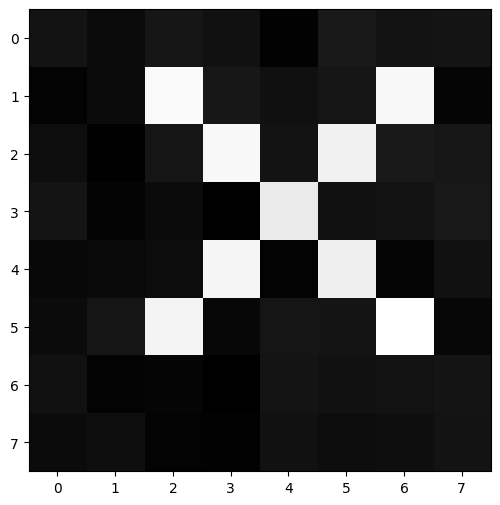

In [373]:
diagonal_cross_pose = [1,2]
diagonal_cross_picture_32 = get_picture(image_resolution, values_range, background_range, figure_range, diagonal_cross_pattern, diagonal_cross_pose)

image = diagonal_cross_picture_32.reshape(*image_resolution)
# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

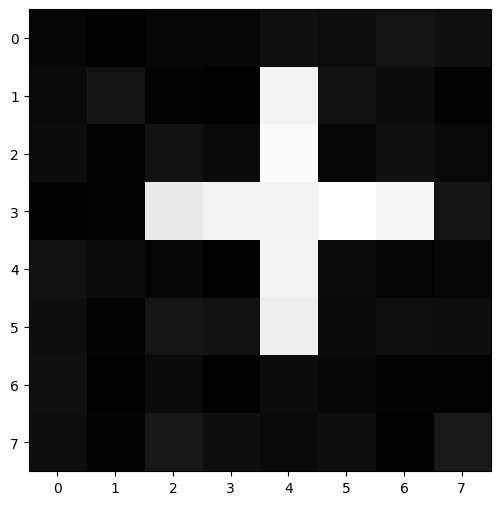

In [374]:
vertical_cross_pose = [1,2]
vertical_cross_picture_32 = get_picture(image_resolution, values_range, background_range, figure_range, vertical_cross_pattern, vertical_cross_pose)

image = vertical_cross_picture_32.reshape(*image_resolution)
# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

### Training set 

In [375]:
n_of_train_data = 25

n_of_samples_for_each_figure = 3

figure_positions = [
    [i, j] for i in range(image_resolution[0]) for j in range(image_resolution[1]) for _ in range(n_of_samples_for_each_figure)] 
# figure_positions = [[i, j] for i in range(image_resolution[0]) for j in range(image_resolution[1]) ] 

diagonal_cross_train_set = np.array([
    get_picture(
        image_resolution,
        values_range,
        background_range,
        figure_range,
        diagonal_cross_pattern,
        pos
    )
    for pos in figure_positions
])


vertical_cross_train_set = np.array([
    get_picture(
        image_resolution,
        values_range,
        background_range,
        figure_range,
        vertical_cross_pattern,
        pos
    )
    for pos in figure_positions
])

diagonal_cross_train_set = [i for i in diagonal_cross_train_set if i is not None]
vertical_cross_train_set = [i for i in vertical_cross_train_set if i is not None]

/var/folders/nh/s04mlxnd00g9yqk9cw_t5wyr0000gn/T/ipykernel_56250/3948455020.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  diagonal_cross_train_set = np.array([
/var/folders/nh/s04mlxnd00g9yqk9cw_t5wyr0000gn/T/ipykernel_56250/3948455020.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vertical_cross_train_set = np.array([


### Validation set 

In [376]:
import random

n_of_test_data= 10

diagonal_cross_validation_set = np.array([
    get_picture(
        image_resolution,
        values_range,
        background_range,
        figure_range,
        diagonal_cross_pattern,
        [random.randint(0, image_resolution[0] - len(diagonal_cross_pattern)), random.randint(0, image_resolution[1] - len(diagonal_cross_pattern))]
    )
    for _ in range(n_of_test_data)
])


vertical_cross_validation_set = np.array([
    get_picture(
        image_resolution,
        values_range,
        background_range,
        figure_range,
        vertical_cross_pattern,
        [random.randint(0, image_resolution[0] - len(vertical_cross_pattern)), random.randint(0, image_resolution[1] - len(vertical_cross_pattern))]
    )
    for _ in range(n_of_test_data)
])

### Test set 

In [377]:
n_of_test_data= 20

diagonal_cross_test_set = np.array([
    get_picture(
        image_resolution,
        values_range,
        background_range,
        figure_range,
        diagonal_cross_pattern,
        [random.randint(0, image_resolution[0] - len(diagonal_cross_pattern)), random.randint(0, image_resolution[1] - len(diagonal_cross_pattern))]
    )
    for _ in range(n_of_test_data)
])


vertical_cross_test_set = np.array([
    get_picture(
        image_resolution,
        values_range,
        background_range,
        figure_range,
        vertical_cross_pattern,
        [random.randint(0, image_resolution[0] - len(vertical_cross_pattern)), random.randint(0, image_resolution[1] - len(vertical_cross_pattern))]
    )
    for _ in range(n_of_test_data)
])

In [378]:
training_set = np.concatenate((diagonal_cross_train_set, vertical_cross_train_set))
validation_set = np.concatenate((diagonal_cross_validation_set, vertical_cross_validation_set))
test_set = np.concatenate((diagonal_cross_test_set, vertical_cross_test_set))

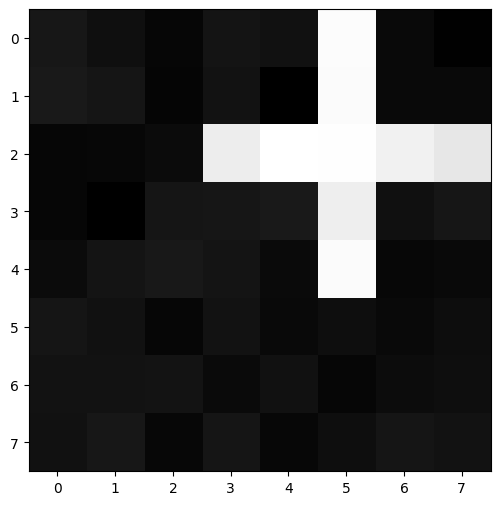

In [379]:
image = vertical_cross_train_set[9].reshape(8, 8)
# plot the three_vertical_line_picture_16
fig = plt.figure
plt.imshow(image , cmap='gray')
plt.show()


## Validation Function

In [380]:
def validate_autoencoder(predicted, actual):
    mse = mean_squared_error(actual, predicted)
    print("MSE:", mse)

    return mse

# Quantum Experiments

## Define function for experiments

In [381]:
import json
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes, EfficientSU2
from qiskit.quantum_info import Statevector
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN

algorithm_globals.random_seed = 42
image_resolution = [8,4]
values_range = image_resolution[0] * image_resolution[1]

In [382]:
def ansatz(num_qubits):
    return EfficientSU2(num_qubits, reps=3)

def auto_encoder_circuit(num_latent, num_trash):
    qr = QuantumRegister(num_latent + 2 * num_trash + 1, "q")
    cr = ClassicalRegister(1, "c")
    circuit = QuantumCircuit(qr, cr)
    circuit.compose(ansatz(num_latent + num_trash), range(0, num_latent + num_trash), inplace=True)
    circuit.barrier()
    auxiliary_qubit = num_latent + 2 * num_trash
    # swap test
    circuit.h(auxiliary_qubit)
    for i in range(num_trash):
        circuit.cswap(auxiliary_qubit, num_latent + i, num_latent + num_trash + i)

    circuit.h(auxiliary_qubit)
    circuit.measure(auxiliary_qubit, cr[0])
    return circuit

def cost_func_digits(params_values, qnn, train_images):
    global objective_func_vals
    probabilities = qnn.forward(train_images, params_values)
    cost = np.sum(probabilities[:, 1]) / train_images.shape[0]

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

    return cost

def identity_interpret(x):
    return x

In [383]:
def validate_quantum_autoencoder(num_trash, num_latent, validate_set, fm, opt_result, return_mse=True):
    global image_resolution
    test_qc_in_function = QuantumCircuit(num_latent + num_trash)
    test_qc_in_function = test_qc_in_function.compose(fm)
    ansatz_qc = ansatz(num_latent + num_trash)
    test_qc_in_function = test_qc_in_function.compose(ansatz_qc)
    test_qc_in_function.barrier()
    for i in list(reversed(range(num_latent + num_trash)))[:num_trash]:
        test_qc_in_function.reset(i)
    test_qc_in_function.barrier()
    test_qc_in_function = test_qc_in_function.compose(ansatz_qc.inverse())

    result_image = []
    for image in validate_set:
        original_qc = fm.assign_parameters(image)
        original_sv = Statevector(original_qc).data
        original_sv = np.reshape(np.abs(original_sv) ** 2, image_resolution)

        param_values = np.concatenate((image, opt_result.x))
        output_qc = test_qc_in_function.assign_parameters(param_values)
        output_sv = Statevector(output_qc).data
        result_image += [np.real(output_sv)]
        
        output_sv = np.reshape(np.abs(output_sv) ** 2, image_resolution)
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(original_sv)
        ax1.set_title("Input Data")
        ax2.imshow(output_sv)
        ax2.set_title("Output Data")
        plt.show()

    mse = mean_squared_error(validate_set, result_image)
    
    return mse if return_mse else test_qc_in_function

In [384]:
def validate_classical_autoencoder(original, predicted):
    global image_resolution

    for og, prd in zip(original, predicted):
        original_sv = np.reshape(og, image_resolution)
        
        output_sv = np.reshape(prd, image_resolution)
        
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(original_sv)
        ax1.set_title("Input Data")
        ax2.imshow(output_sv)
        ax2.set_title("Output Data")
        plt.show()

    return mean_squared_error(original, predicted)

### Quantum circuits

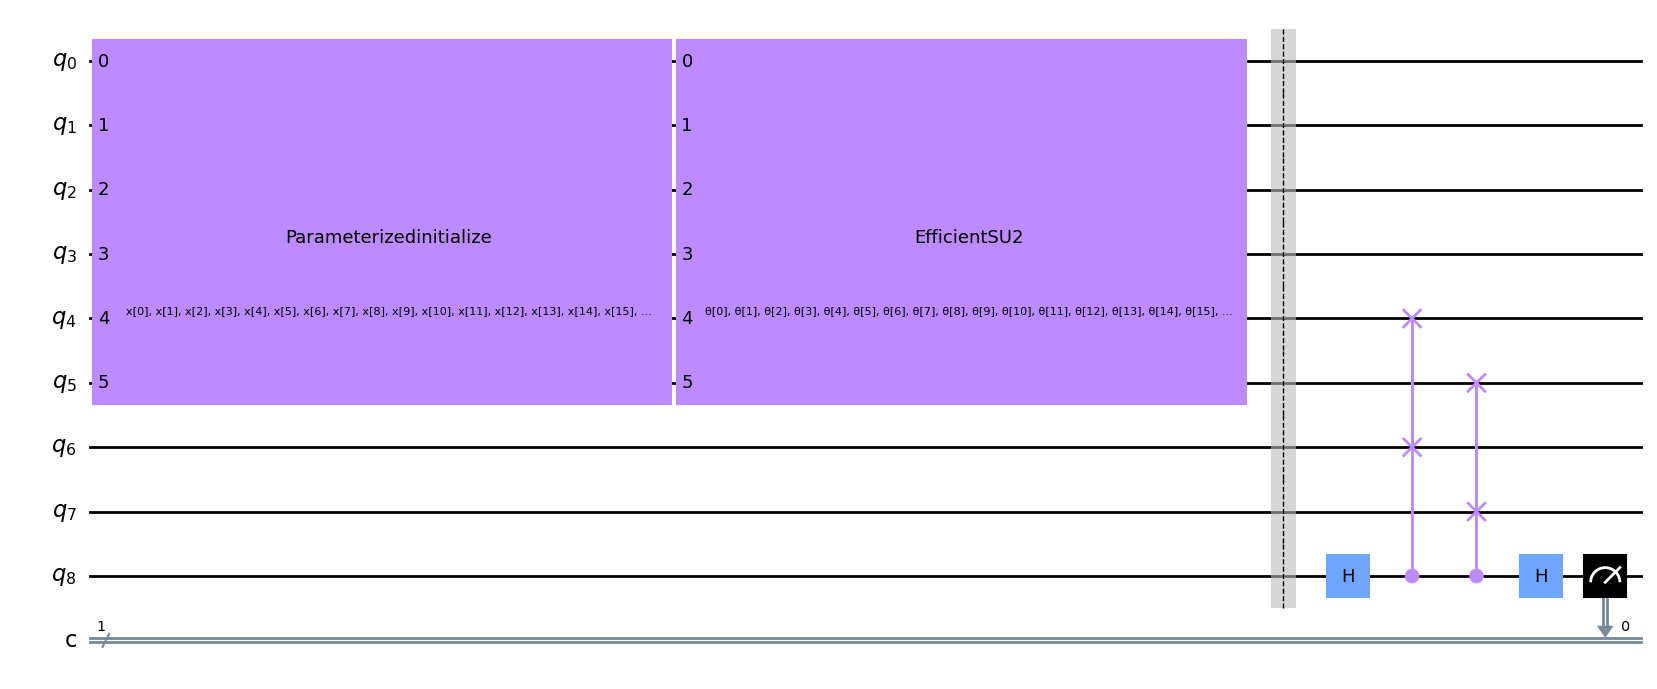

In [385]:
def get_quantum_cir(num_latent, num_trash):
    fm = RawFeatureVector(2 ** (num_latent + num_trash))

    ae = auto_encoder_circuit(num_latent, num_trash)

    qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)

    qc = qc.compose(fm, range(num_latent + num_trash))
    qc = qc.compose(ae)

    # transpiled = transpile(qc, backend=backend)

    qc.draw("mpl")
    
    return fm, ae, qc

num_latent = 4
num_trash = 2
fm_64_4_2, ae_64_4_2, qc_64_4_2 = get_quantum_cir(num_latent, num_trash)

qc_64_4_2.draw("mpl")

In [386]:
qnn_64 = SamplerQNN(
    circuit=qc_64_4_2,
    input_params=fm_64_4_2.parameters,
    weight_params=ae_64_4_2.parameters,
    interpret=identity_interpret,
    output_shape=2,
)

algorithm_globals.random_seed = 42
initial_point_64 = algorithm_globals.random.random(ae_64_4_2.num_parameters)

## Experiment

### Two cross model 

In [387]:
len(training_set)

96

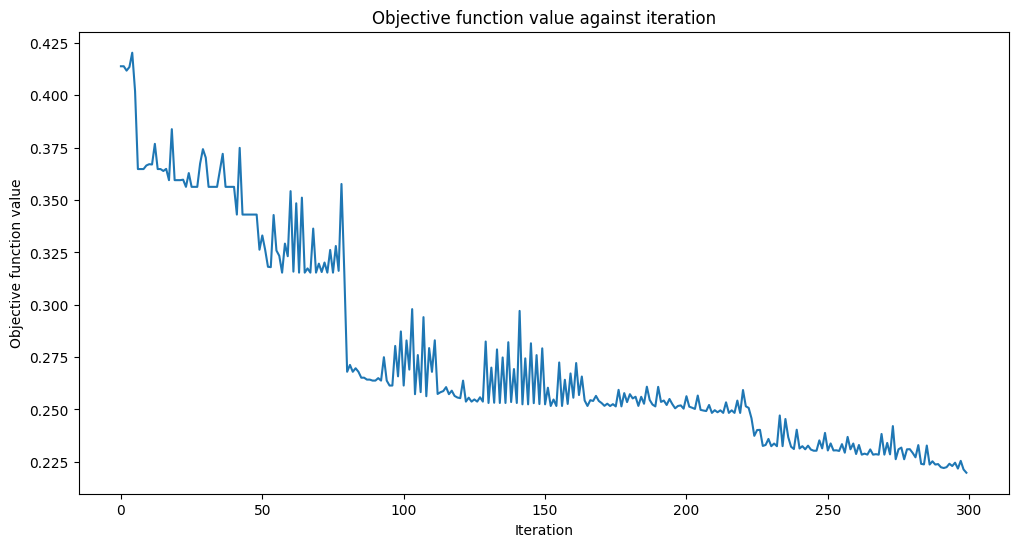

Fit in 268.13 seconds


In [388]:
# opt_result_three_horizontal_picture
opt = COBYLA(maxiter=300)
objective_func_vals = []
# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()

opt_result = opt.minimize(
    fun=partial(
        cost_func_digits,
        qnn=qnn_64,
        train_images=training_set), x0=initial_point_64)
elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} seconds")

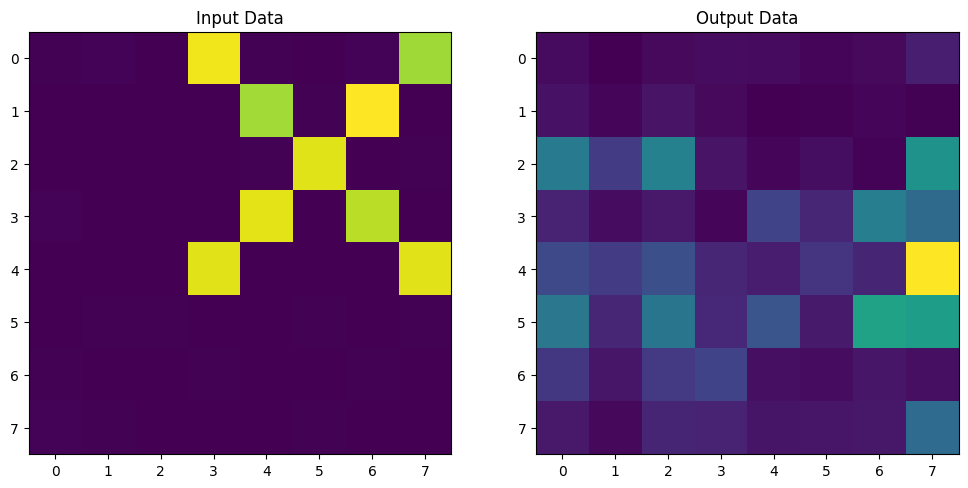

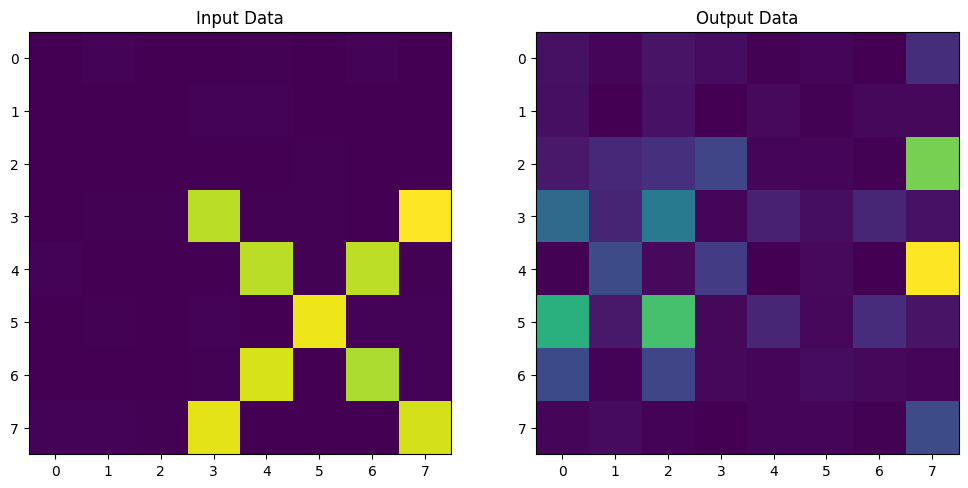

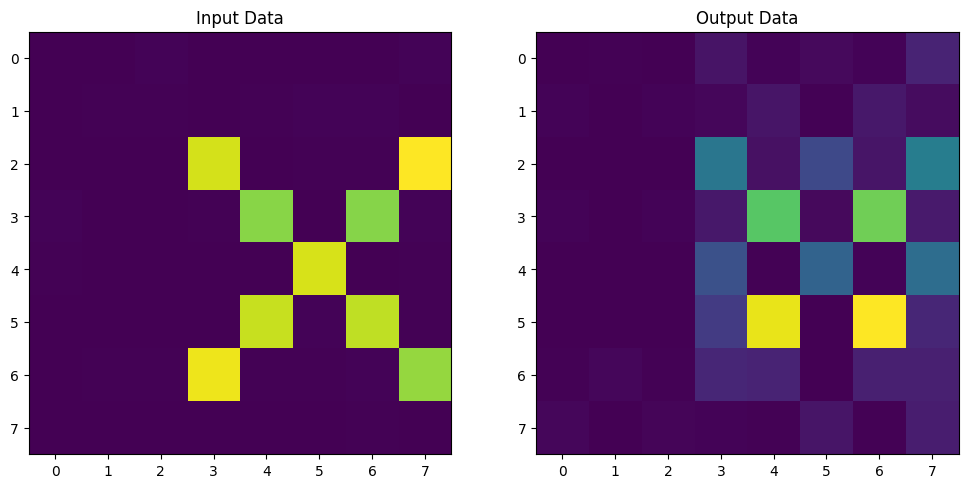

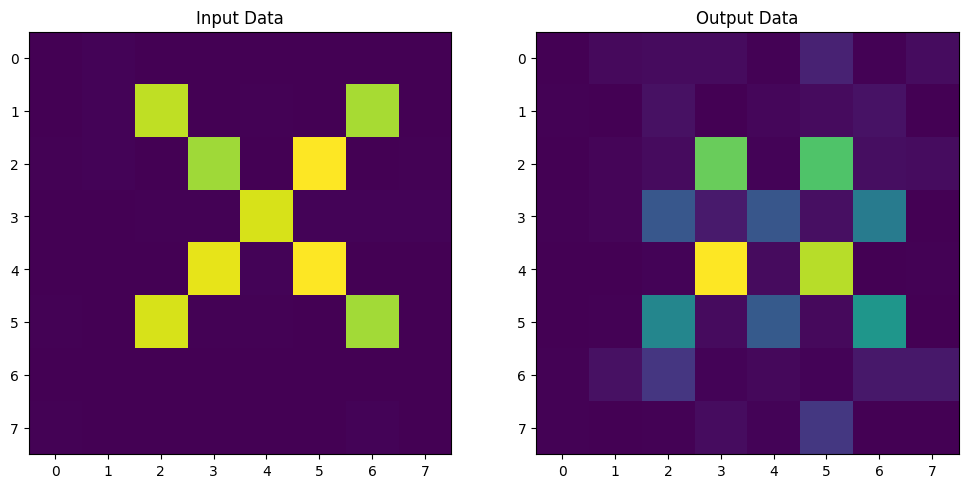

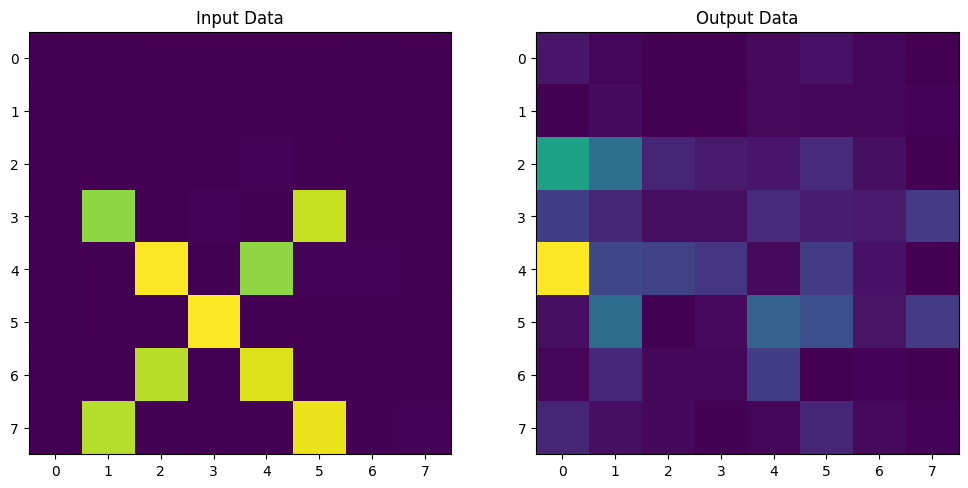

In [389]:
image_resolution = (8, 8)

quantum_diagonal_mse = validate_quantum_autoencoder(
        num_trash, num_latent, diagonal_cross_test_set[:5],
        fm_64_4_2, opt_result)

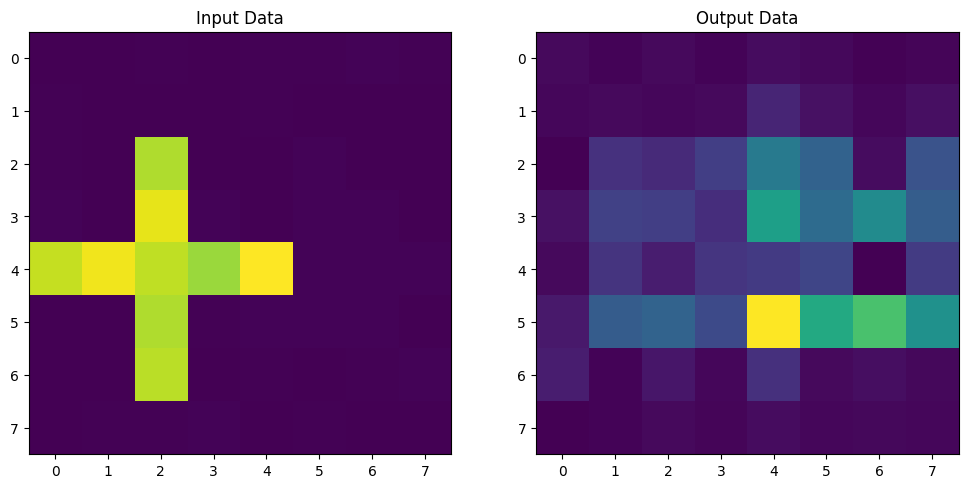

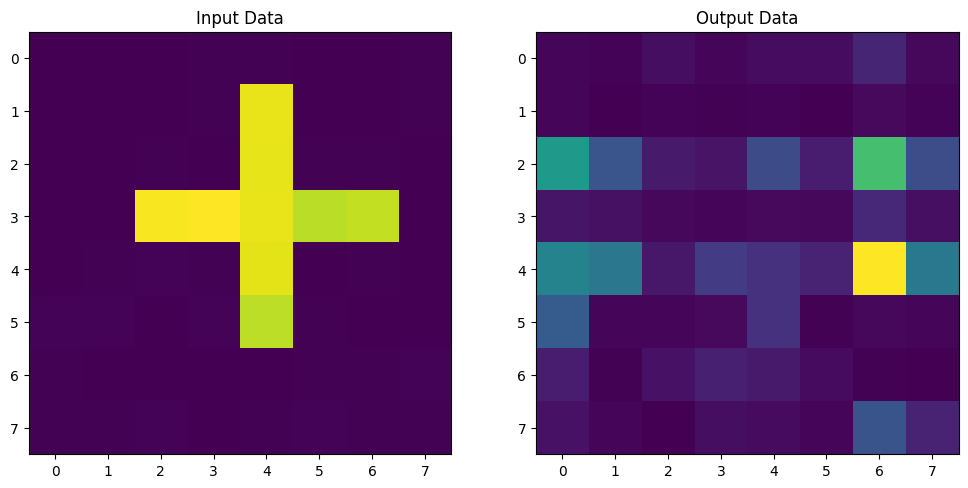

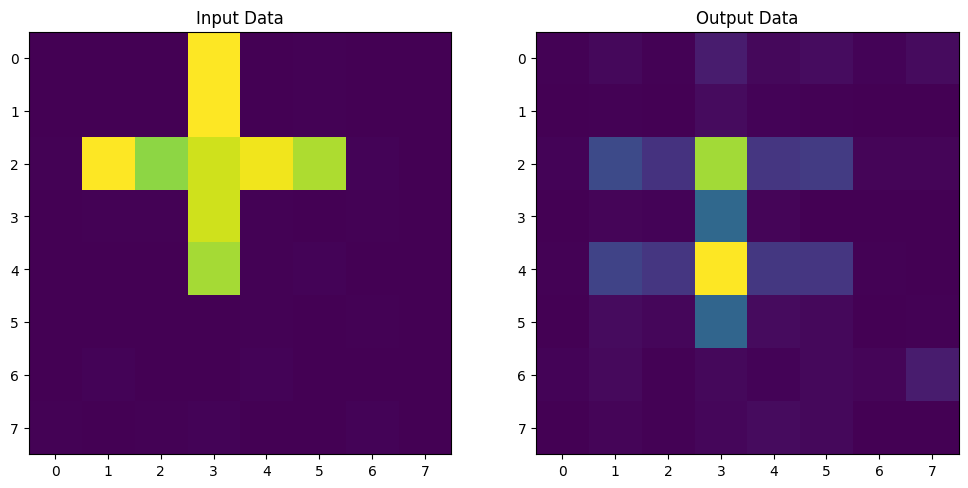

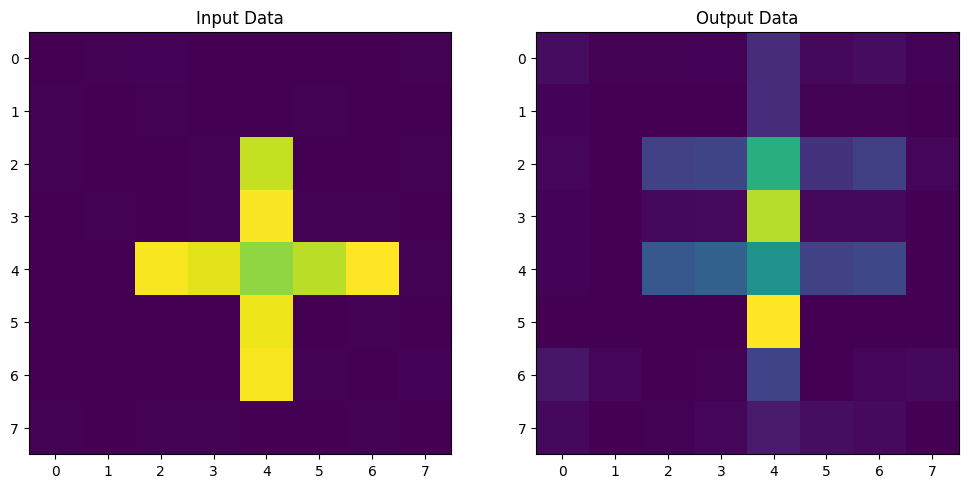

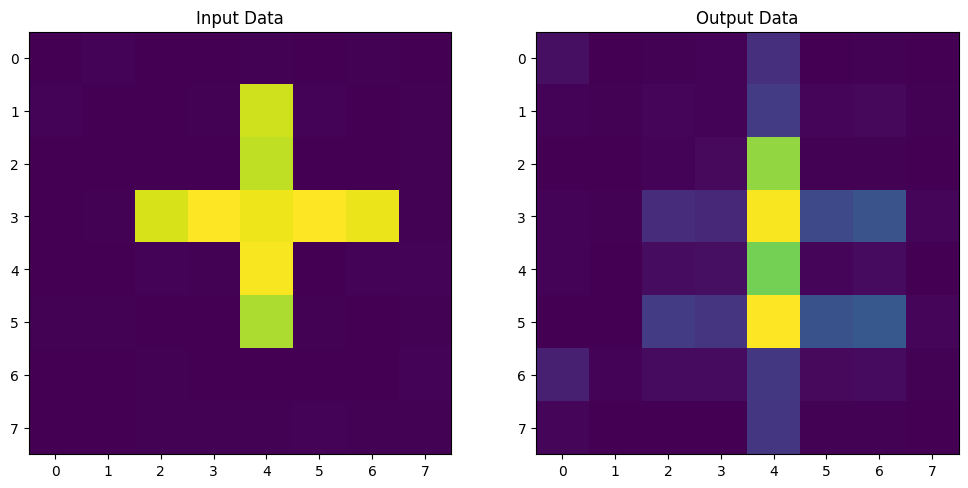

In [390]:
image_resolution = (8, 8)

quantum_vertical_mse = validate_quantum_autoencoder(
        num_trash, num_latent, vertical_cross_test_set[:5],
        fm_64_4_2, opt_result)

# Classical Experiment

In [391]:
image_resolution = [8, 8]
values_range = image_resolution[0] * image_resolution[1]

In [392]:
encoding_dim = 16

input_img = Input(shape=(values_range,))
encoded = tf.keras.layers.Dense(64, activation='relu')(input_img)
encoded = tf.keras.layers.Dense(32, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(encoding_dim, activation='relu', name="bottleneck")(encoded)
decoded = tf.keras.layers.Dense(32, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(64, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(values_range, activation='sigmoid')(decoded)

# Create the autoencoder model
autoencoder = Model(input_img, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

test_data = []
mse_result = []


trained_model = autoencoder.fit(
        training_set,
        training_set,
        batch_size=3,
        epochs= 350,
        shuffle=True,
        verbose=0,
        validation_data=(validation_set, validation_set),
    )

encoder = Model(autoencoder.input, autoencoder.get_layer("bottleneck").output)
encoded_data = encoder.predict(training_set)  # bottleneck representation
decoded_output = autoencoder.predict(training_set)  # reconstruction

# return the decoder
encoded_input = Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-3](encoded_input)
decoder = Model(encoded_input, decoder)

mse = mean_squared_error(test_set, autoencoder.predict(test_set))

print(mse)


2/2 [==============================] - 0s 1ms/step
0.00027896642785259364


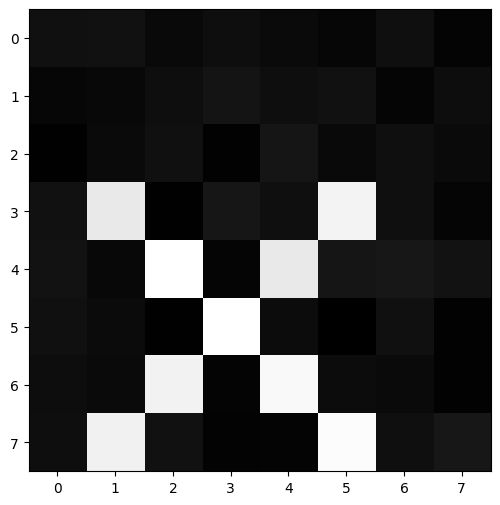

In [393]:
sample = 3
image = test_set[4].reshape(8, 8)
# plot the sample
fig = plt.figure

plt.imshow(image, cmap='gray')
plt.show()

2/2 [==============================] - 0s 2ms/step


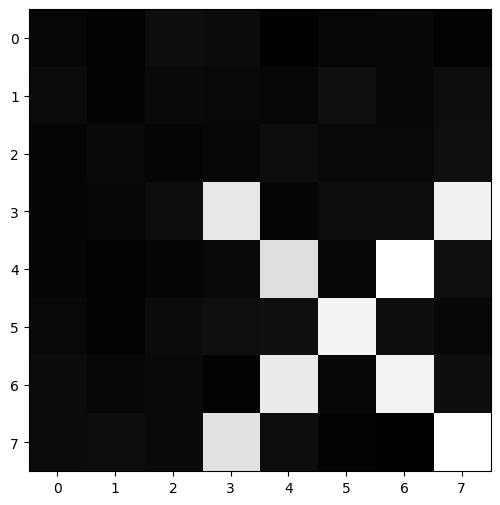

In [394]:
image = autoencoder.predict(test_set)[1].reshape(*image_resolution)
# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

1/1 [==============================] - 0s 20ms/step


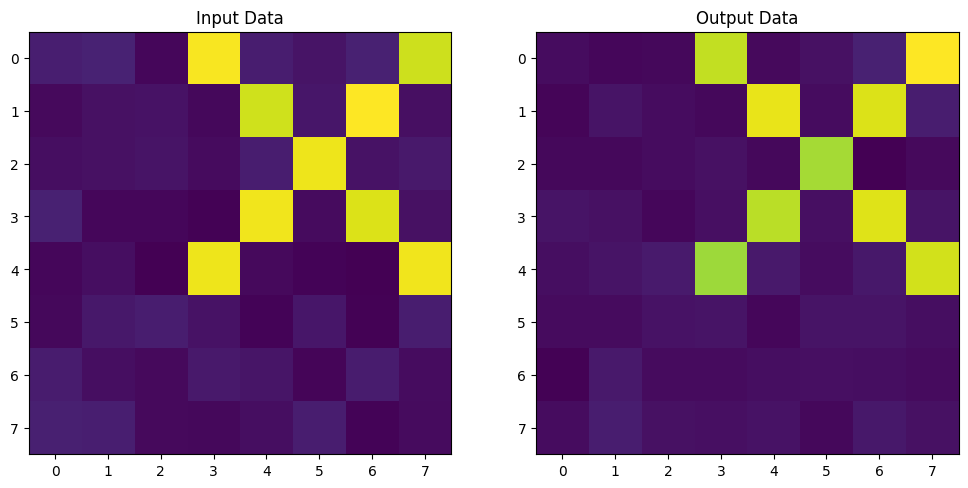

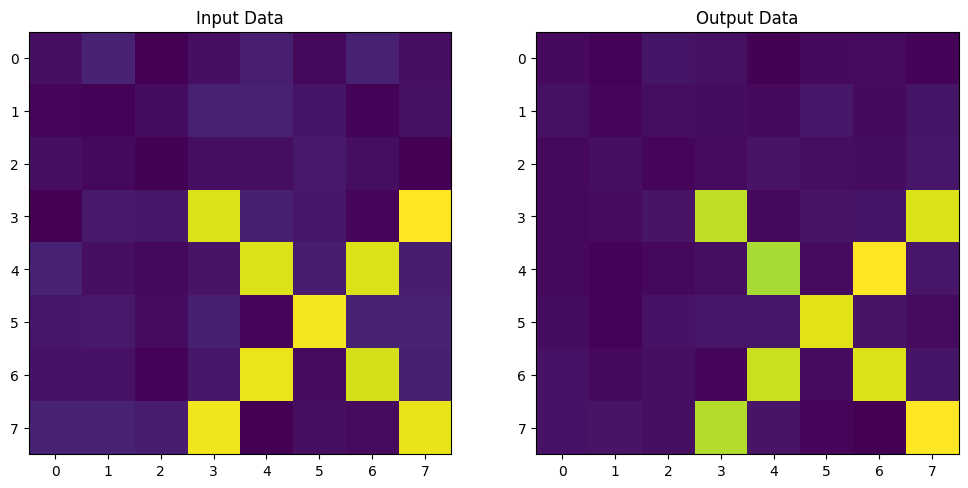

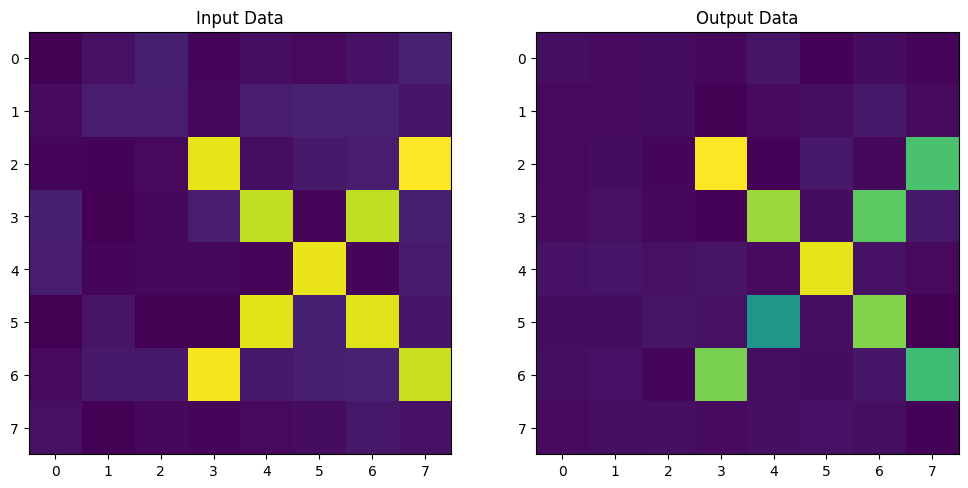

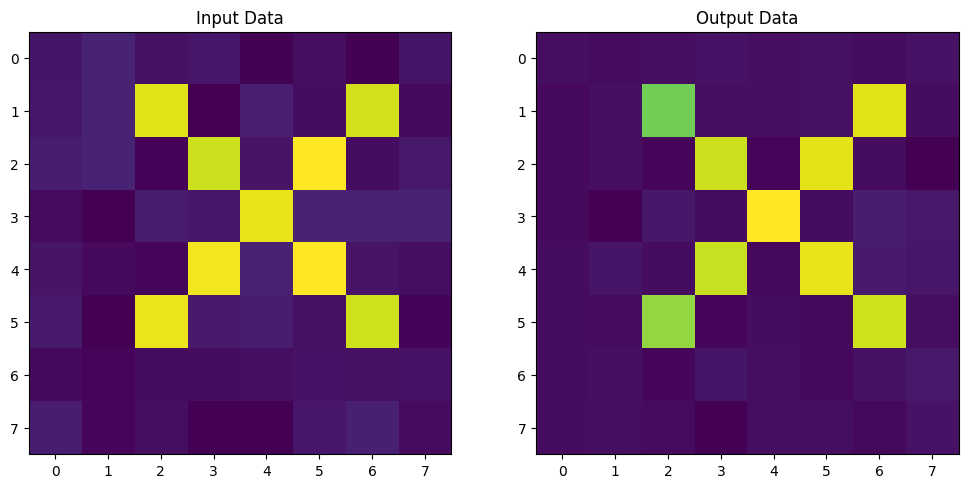

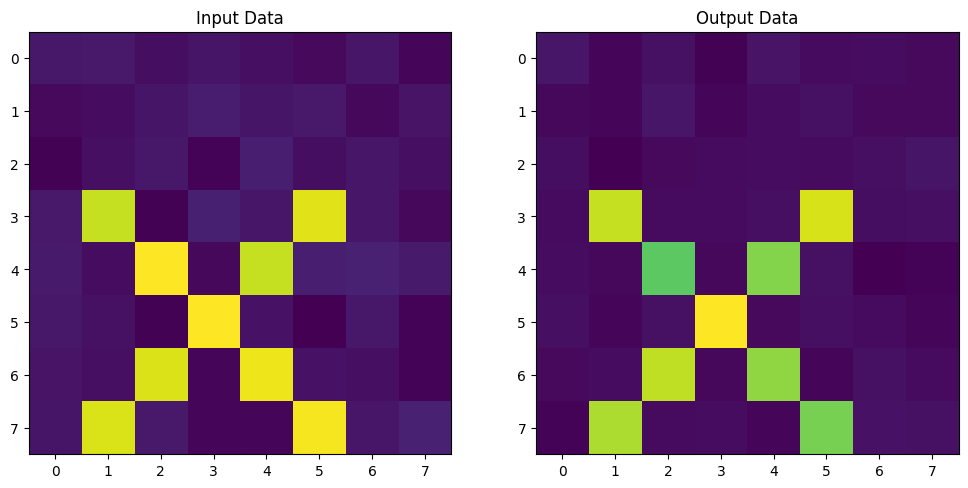

0.00033623157474611934

In [395]:
classical_diagonal_mse = validate_classical_autoencoder(
    diagonal_cross_test_set[:5],
    autoencoder.predict(diagonal_cross_test_set[:5]))
classical_diagonal_mse

1/1 [==============================] - 0s 12ms/step


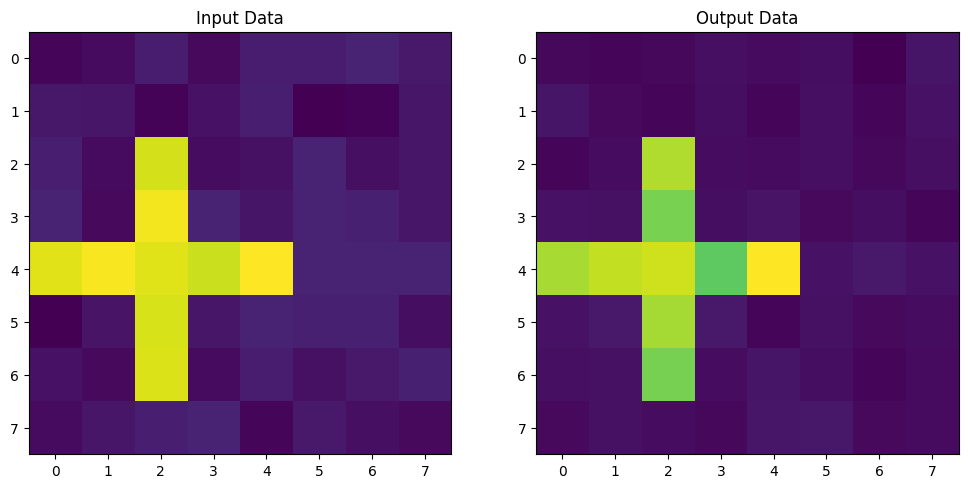

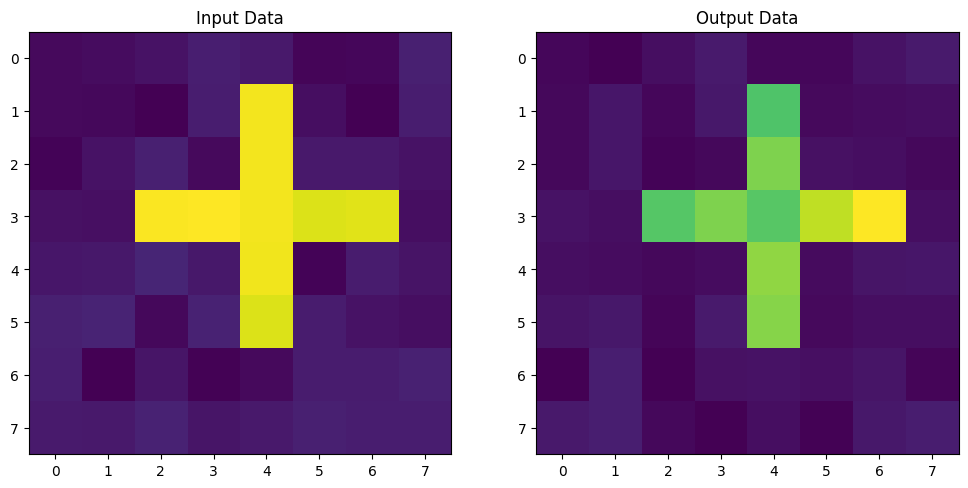

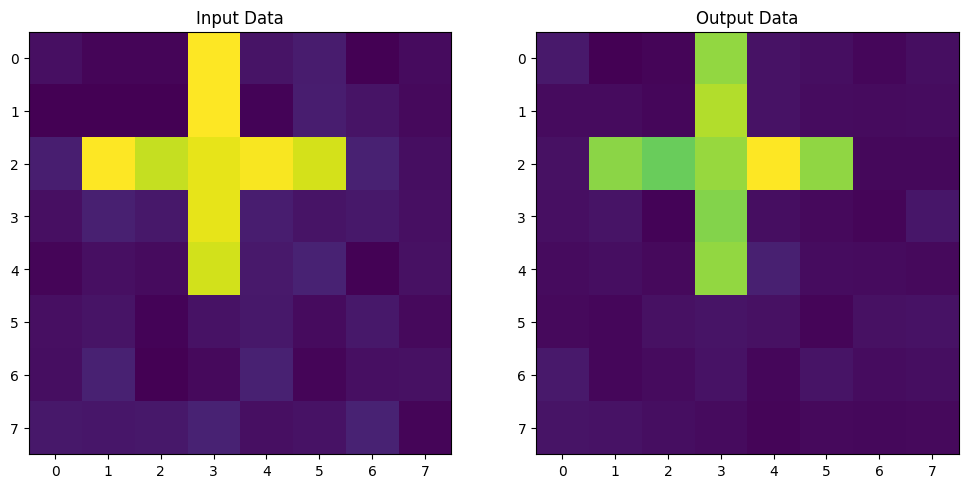

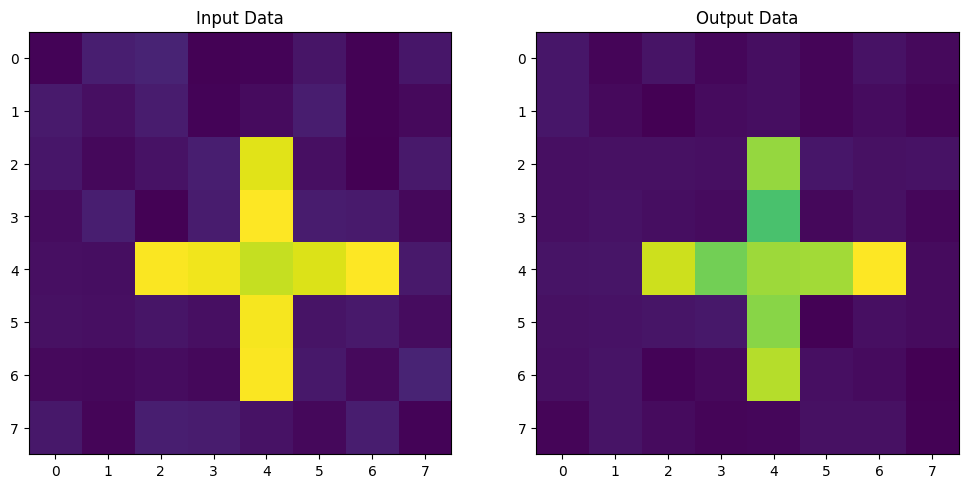

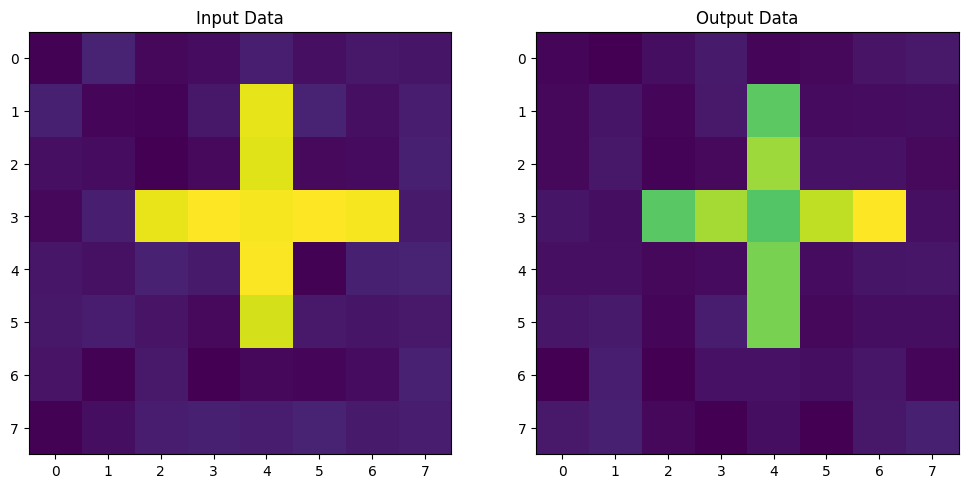

0.000260124030183712

In [396]:
classical_vertical_mse = validate_classical_autoencoder(
    vertical_cross_test_set[:5],
    autoencoder.predict(vertical_cross_test_set[:5])
    )
classical_vertical_mse

# Results

In [397]:
print("MSE classical for diagonal / cross figures:", classical_diagonal_mse)
print("MSE classical for vertical | cross figures:", classical_vertical_mse)

classical_combined_mse = (classical_diagonal_mse + classical_vertical_mse) / 2

print("MSE for classical model:", classical_combined_mse)

MSE classical for diagonal / cross figures: 0.00033623157474611934
MSE classical for vertical | cross figures: 0.000260124030183712
MSE for classical model: 0.00029817780246491564


In [398]:
print("MSE quantum for diagonal / cross figures:", quantum_diagonal_mse)
print("MSE quantum for vertical | cross figures:", quantum_vertical_mse)

quantum_combined_mse = (quantum_diagonal_mse + quantum_vertical_mse) / 2

print("MSE for quantum model:", quantum_combined_mse)

MSE quantum for diagonal / cross figures: 0.015088030889607513
MSE quantum for vertical | cross figures: 0.012663055055500045
MSE for quantum model: 0.013875542972553778
